# LAB 3: LINEAR REGRESSION USING ROBUST FUNCTIONS

## 1. INTRODUCTION

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We start by generating a random set of points around the first bisector of the plane (following a normal distribution).

In [2]:
def generate_sample(angle_deg=45, n_samples=100):
    m = [0.,0.]
    angle = angle_deg * np.pi / 180
    rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    
    lamb = np.array([[n_samples, 0],[0, 1]])
    s = np.dot(rot, np.dot(lamb, rot.T))
    c = np.random.multivariate_normal(m, s, n_samples)
    
    return c

In [3]:
c = generate_sample()
x, y = c[:, 0].ravel(), c[:, 1].ravel()

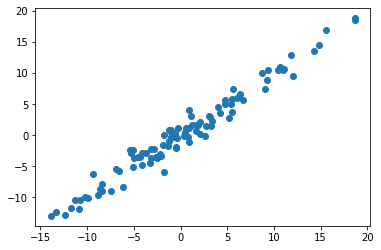

In [4]:
plt.scatter(x, y)

To perform the linear regression, we define the least squares error (our objective/cost function) and its gradient.

In [5]:
def error(x, y, w):
    return 1 / 2 * np.sum((w[0] * x + w[1] - y) ** 2)

def grad_error(x, y, w):
    return np.array([np.sum((w[0] * x + w[1] - y) * x), np.sum(w[0] * x + w[1] - y)])

As our learning algorithm, we will use the gradient descent method with a very small constant stepsize (we decided not to include backtracking since this way works smoother and faster for this kind of problem).

In [6]:
def gradient_descent(x, y, f, grad_f, tol=1e-5, max_iter=1000):
    np.random.seed(42)
    w = np.random.uniform(0, 1, (2, ))
    n = 0
    alpha = 0.0001
    
    while np.linalg.norm(grad_f(x, y, w)) >= tol and n < max_iter:        
        n = n + 1
        w = w - alpha * grad_f(x, y, w)
    
    return w, n

In [7]:
w_opt, n = gradient_descent(x, y, error, grad_error)
print(w_opt)

[0.97045128 0.0462755 ]


Having calculated the optimal parameters for the regression, let us plot the line that fits our data set:

In [8]:
def plot_fitted_line(x, y, w, title='', y_range=None):
    plt.clf()
    
    plt.plot(x, w[0] * x + w[1], 'r')
    plt.scatter(x, y)
    
    plt.title(title)
    
    if y_range:
        plt.ylim(*y_range)
    
    plt.show()

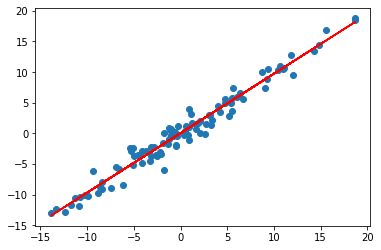

In [9]:
plot_fitted_line(x, y, w_opt)

As a standard linear regression with the least squares method, it works as expected. But we will test what happens if we exchange one of the original points of our dataset by an outlier. 

In [10]:
x_noisy = np.copy(x)
y_noisy = np.copy(y)

x_noisy[1] = -40
y_noisy[1] = 20

In [11]:
w_opt, n = gradient_descent(x_noisy, y_noisy, error, grad_error)
print(w_opt)

[0.61200135 0.55865798]


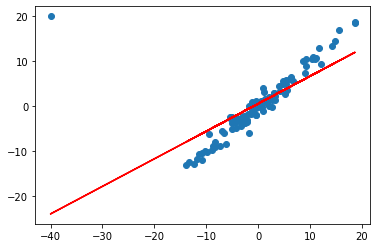

In [12]:
plot_fitted_line(x_noisy, y_noisy, w_opt)

The influence on the fit that a single outlier has is quite noticeable. The slope of the fitted line (with the new parameters found) has changed, overall, for the worse since the LS error has obviously increased on the rest of the dataset in order to neutralize the effect of the outlier.  

We will now generate other noisy data samples using again the original random dataset and exchanging multiple random points by others which are outliers as before:

In [13]:
def generate_noisy_sample(x, y, prop=0.1):
    noisy_x = np.copy(x)
    noisy_y = np.copy(y)
    
    num_points = int(x.shape[0] * prop)
    noisy_idx = np.random.choice(x.shape[0], num_points)
    
    noisy_x[noisy_idx] = np.random.choice(np.arange(-40, 40), size=num_points)
    noisy_y[noisy_idx] = np.random.choice(np.arange(-20, 20), size=num_points)
    
    return noisy_x, noisy_y

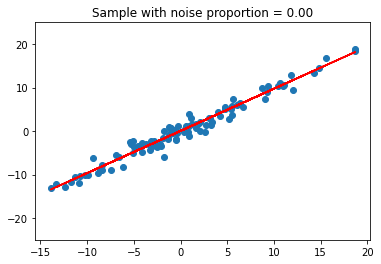

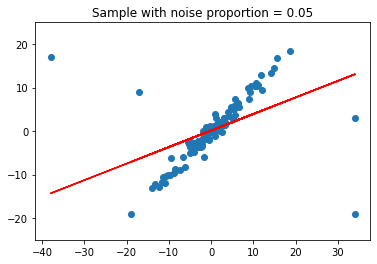

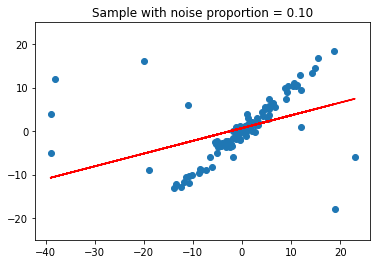

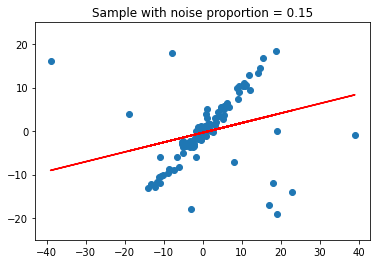

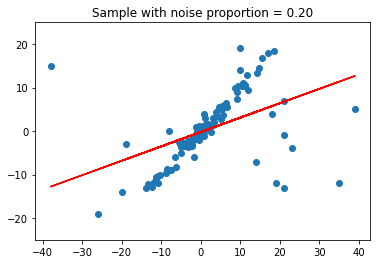

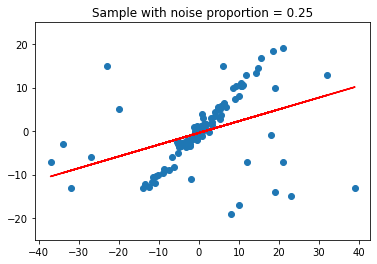

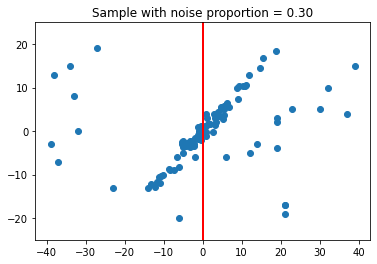

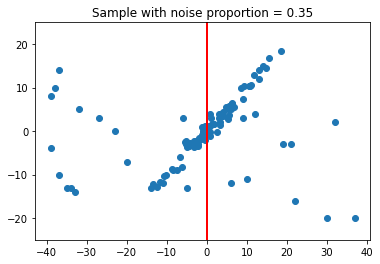

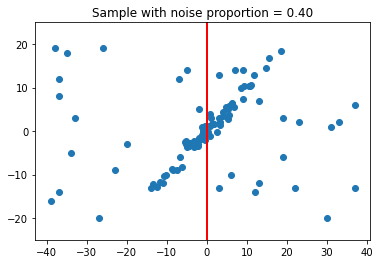

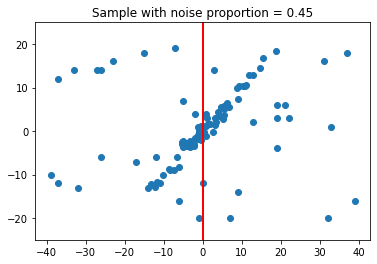

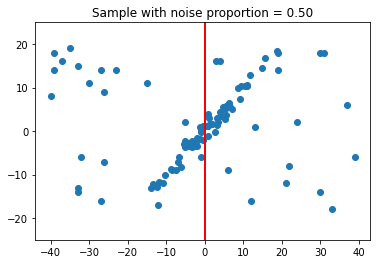

In [14]:
noise_props = np.arange(0, 0.55, 0.05)

for prop in noise_props:
    # Generate noisy sample
    x_noisy, y_noisy = generate_noisy_sample(x, y, prop=prop)
    
    w_opt, n = gradient_descent(x_noisy, y_noisy, error, grad_error)
    
    plot_fitted_line(x_noisy, y_noisy, w_opt, title=f'Sample with noise proportion = {prop:.2f}', y_range=(-25, 25))

As we can see, when we add a few outliers (small noise proportions) the behaviour is the same as before. Since we performed a fitting using vertical offsets, this approach leads us to a high sensitivy for outliers with this method (with a quadratic error function) since our fitted line has to change greatly in order to countereffect the huge residual errors generated by them. When the noise proportion is higher (0.3 and bigger), we are presented with several points that cover all the neighbour space from the bulk of the sample and the only way to minimize the cost function is to fit it by the vertical axis.

As we can see, by that point, the influence of the outliers makes our regression useless. 

## 2. ROBUST FUNCTIONS

In order to create a method that is less sensitive to outliers, we will now study the use of robust functions as our new error functions, with the cost function being the sum of the chosen error function evaluated at every residual error, that is, $\sum_{i=1}^{nsamples}\rho(e_i)$. In this case, we will make use of the Cauchy function, $\rho(u)=\frac{c^2}{2}log\left[1+\left(\frac{u}{c}\right)^2\right]$, as the error function and we will see what happens differently than with the LS error function, $\rho(u)=\frac{1}{2}u^2$.

In [15]:
def least_squares_function(u):
    return 0.5 * u**2

def cauchy_function(u, c=1):
    return (c**2 / 2) * np.log(1 + (u / c)**2)

We will use the same data sample as in the firt part of this notebook. Let us compare both error functions (assuming $c=1$):

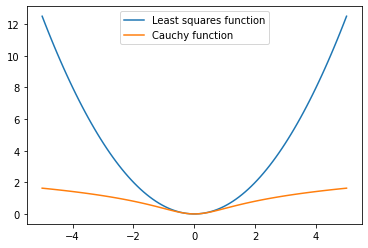

In [16]:
x_values = np.linspace(-5, 5, 100)

plt.clf()

plt.plot(x_values, least_squares_function(x_values), label='Least squares function')
plt.plot(x_values, cauchy_function(x_values), label='Cauchy function')

plt.legend()
plt.show()

We can see that the Cauchy functions is pointier towards the center and its subquadratic behaviour allows for a far less importance given to the prediction errors, which will have a positive impact on the presence of outliers for this new method.

Now, using the same gradient descent algorithm that we used before, we will compare the results for the fits using both functions and with no outliers in the dataset:

In [17]:
def cauchy(x, y, w, c=1):
    return (c**2 / 2) * np.sum(np.log(1 + ((w[0] * x + w[1] - y) / c)**2))


def grad_cauchy(x, y, w, c=1):
    error = w[0] * x + w[1] - y
    error_ratio = (c**2 * error) / (c**2 + error**2)
    
    return np.array([np.sum(x * error_ratio), np.sum(error_ratio)])

def gradient_descent_cauchy(x, y, c=1, tol=1e-5, max_iter=1000):
    np.random.seed(42)
    w = np.random.uniform(0, 1, (2, ))
    n = 0
    alpha = 0.0001
    
    while np.linalg.norm(grad_cauchy(x, y, w)) >= tol and n < max_iter:        
        n = n + 1
        w = w - alpha * grad_cauchy(x, y, w, c)
    
    return w, n

In [18]:
def plot_fitted_line_comparison(x, y, w_ls, w_cauchy):
    plt.clf()
    
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    ax1.scatter(x, y)
    ax1.plot(x, w_ls[0] * x + w_ls[1], 'r')
    ax1.title.set_text('Gradient descent with LS error function')
    
    ax2.scatter(x, y)
    ax2.plot(x, w_cauchy[0] * x + w_cauchy[1], 'r')
    ax2.title.set_text('Gradient descent with Cauchy error function')
    
    plt.show()

In [19]:
w_ls, n = gradient_descent(x, y, error, grad_error)
w_cauchy, n = gradient_descent_cauchy(x, y)

print(w_ls)
print(w_cauchy)

[0.97045128 0.0462755 ]
[0.97838094 0.12462522]


<Figure size 432x288 with 0 Axes>

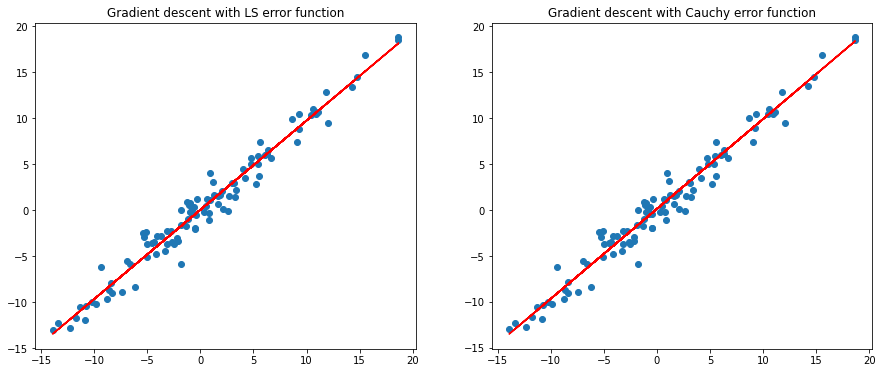

In [20]:
plot_fitted_line_comparison(x, y, w_ls, w_cauchy)

The results are quite similar and both offer pretty good predictions for this dataset. Let's proceed by introducing an outlier to the sample in order to check the usefulness of the Cauchy function:

In [21]:
x_noisy = np.copy(x)
y_noisy = np.copy(y)

x_noisy[1] = -40
y_noisy[1] = 20

In [22]:
w_ls, n = gradient_descent(x_noisy, y_noisy, error, grad_error)
w_cauchy, n = gradient_descent_cauchy(x_noisy, y_noisy)

print(w_ls)
print(w_cauchy)

[0.61200135 0.55865798]
[0.97713526 0.11329996]


<Figure size 432x288 with 0 Axes>

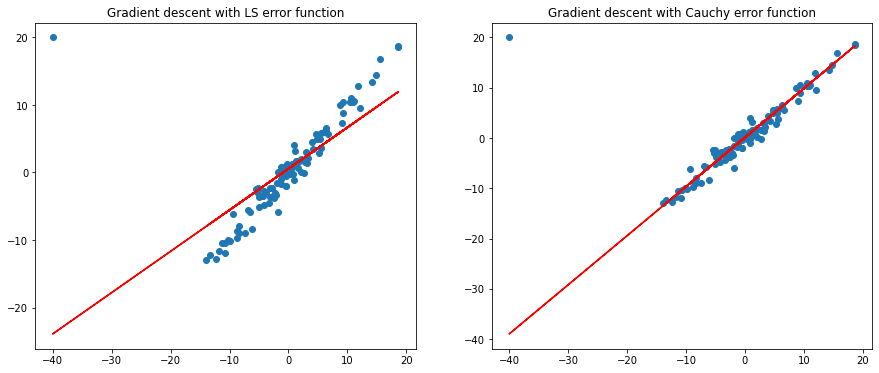

In [23]:
plot_fitted_line_comparison(x_noisy, y_noisy, w_ls, w_cauchy)

Indeed, the linear regression using the LS error function fails once again but the linear regression using the Cauchy function provides a perfect fit for the sample, excluding the outlier previously introduced.

Although we can already see why this happens looking at both functions (and the respective contrubutions of the residual errors), let us do a more exhaustive analysis of this phenomena.

For simplicity, let's assume that our regression only depends on one parameter $\theta$. Then, we can write:
$$  \frac{\partial\sum_{i=1}^{n}\rho(e_i(\theta))}{\partial\theta} = \sum_{i=1}^{n}w(e_i(\theta))e_i\frac{\partial e_i}{\partial\theta}(\theta) $$
where we can define the **weight function** as $w(e_i):=\frac{\frac{\partial\rho}{\partial e_i}(e_i)}{e_i}$. Integrating the equation above, we can obtain the cost function:
$$ \sum_{i=1}^{n}\rho(e_i(\theta))\approx\sum_{i=1}^{n}\int w(e_i(\theta))e_i\frac{\partial e_i}{\partial\theta}(\theta) d\theta. $$




Here, we can already see how important the weight function is since it measures the contribution of each single prediction error to the whole of the loss function that we aim to minimize. Actually, if we managed to move the weight function out of the integral by any suppositions necessary, we would get a reweighed least squares problem. 

For the LS case, this is immediate since we can easily see that $w_{LS}(e)=1$. Following this logic, the weight function associated to the Cauchy function will show us how different is the way in which the prediction errors contribute to the loss when we use the Cauchy function compared than when we use the LS function. Doing the pertinent derivations:
$$ w_C(e)=\frac{1}{1+\left(\frac{e}{c}\right)^2}. $$

For $c=1$, we have that $w_C(e)=\frac{1}{1+e^2}$ and it is easy to see that for small residual values (lower than 1), the weight varies between 0.5 and 1 but for greater residual values the weight tends to zero (quadraticly). This justifies the fact that the outliers don't interfere in the minimization problem since the huge outliers prediction errors have almost a null weight. 

Let us study how the regression changes when we change the parameter $c$ of the Cauchy function. We can start by plotting the function with different values of this parameter:

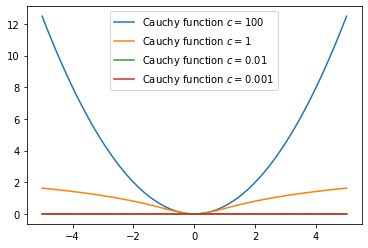

In [24]:
x_values = np.linspace(-5, 5, 100)
c_values = (100, 1, 0.01, 0.001)

plt.clf()

for c in c_values:
    plt.plot(x_values, cauchy_function(x_values, c=c), label=fr'Cauchy function $c={c}$')

plt.legend()
plt.show()

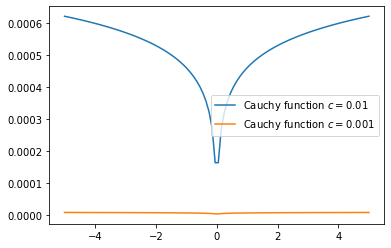

In [25]:
x_values = np.linspace(-5, 5, 100)
c_values = (0.01, 0.001)

plt.clf()

for c in c_values:
    plt.plot(x_values, cauchy_function(x_values, c=c), label=fr'Cauchy function $c={c}$')

plt.legend()
plt.show()

We can also explain the changing of the shape of the Cauchy function that we just plotted for different values of $c$ using the expression of its weight function:

When $c\to +\infty$ (big values of $c$), we have that $w_C\to1=w_{LS}$ and we can see the parabolic shape of the function.

When $c\to0$ (small values of $c$), our weight function tends to zero for all the residual errors different than zero (in practice, almost null). This is the behaviour that we can observe at the second two plots that we had to repeat due to the small values in play, where the function tends to zero in that peculiar way where it keeps being pointy towards the center.


Now, let's plot the different regressions obtained:

LS solution: [0.97045128 0.0462755 ]	Cauchy solution with c = 1: [0.97838094 0.12462522]


<Figure size 432x288 with 0 Axes>

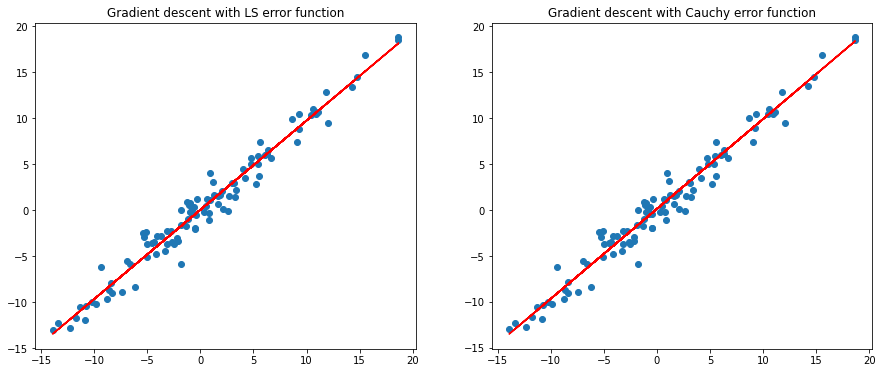

LS solution: [0.97045128 0.0462755 ]	Cauchy solution with c = 100: [0.97045736 0.04630325]


<Figure size 432x288 with 0 Axes>

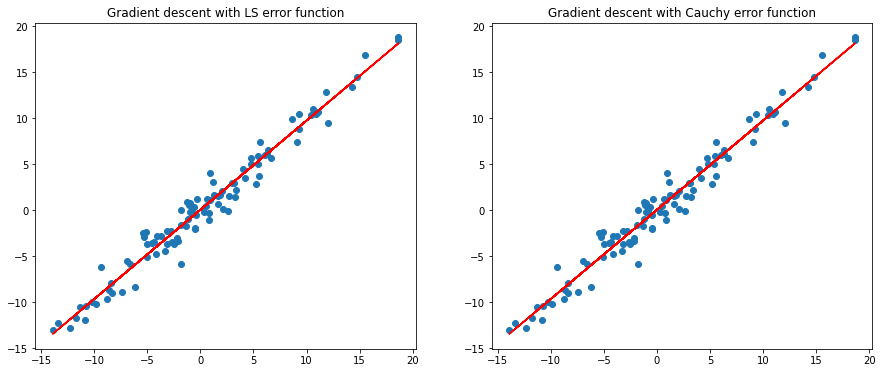

LS solution: [0.97045128 0.0462755 ]	Cauchy solution with c = 0.01: [0.3751494  0.95147214]


<Figure size 432x288 with 0 Axes>

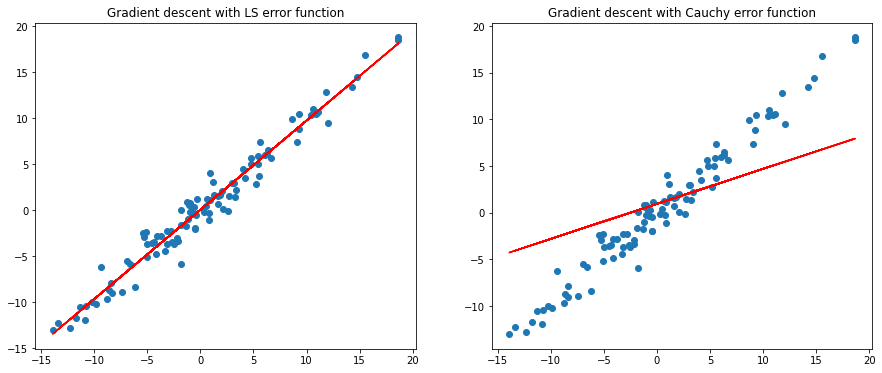

LS solution: [0.97045128 0.0462755 ]	Cauchy solution with c = 0.001: [0.37454735 0.95072799]


<Figure size 432x288 with 0 Axes>

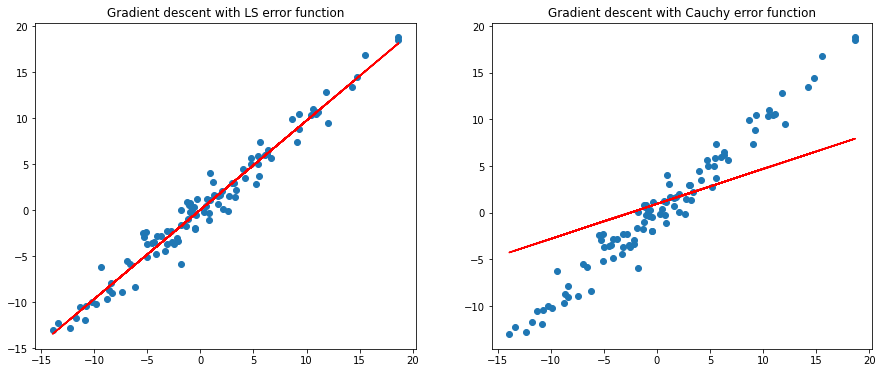

In [26]:
c_values = (1, 100, 0.01, 0.001)

for c in c_values:
    w_ls, n = gradient_descent(x, y, error, grad_error)
    w_cauchy, n = gradient_descent_cauchy(x, y, c=c)
    
    print(f'LS solution: {w_ls}\tCauchy solution with c = {c}: {w_cauchy}')
    
    plot_fitted_line_comparison(x, y, w_ls, w_cauchy)

There are no outliers since we used the first data set. However, this shows how, after the first two plots (both methods amount a good linear prediction), the Cauchy error function fails to find a good fit and the fitted line is always the same. This is because $c$ is so small and the error function is almost constantly zero. Indeed, it is clear that very small values of $c$ can end up making the Cauchy function useless for the optimization problem. 

Nonetheless, we still have to test how this parameter and the method itself works with the number of outliers introduced in our data sample. We will do this with the values $c=1$ and $c=0.01$:

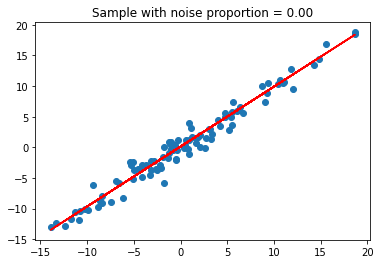

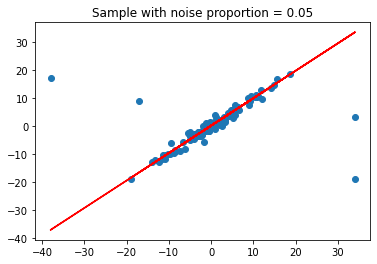

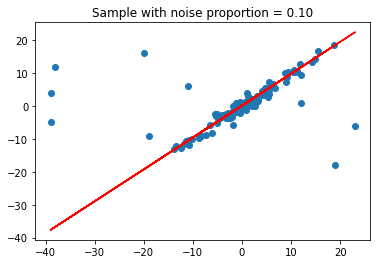

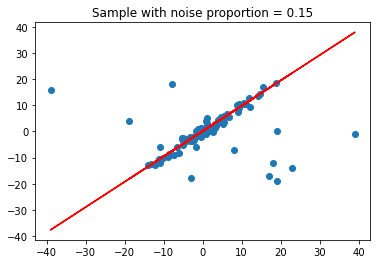

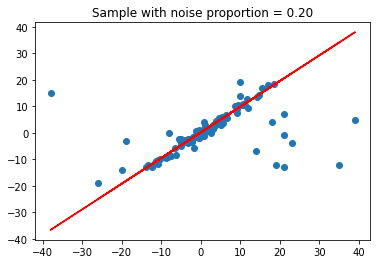

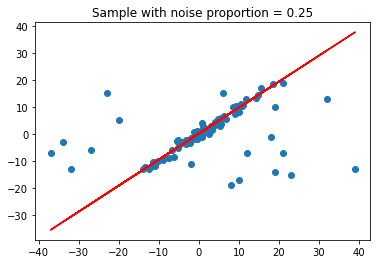

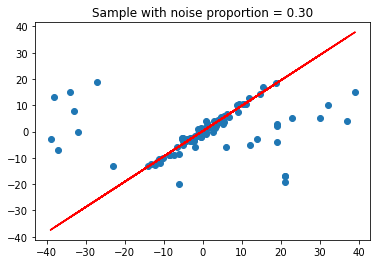

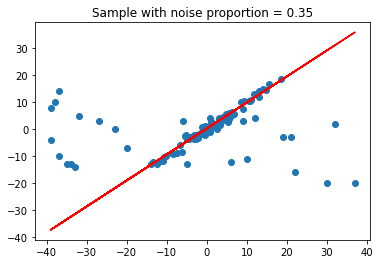

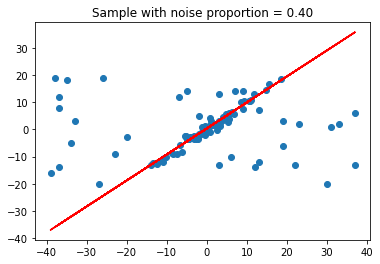

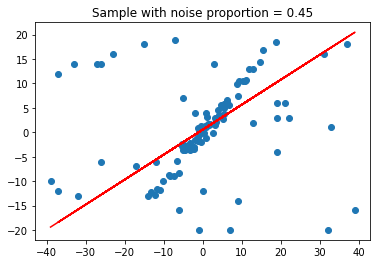

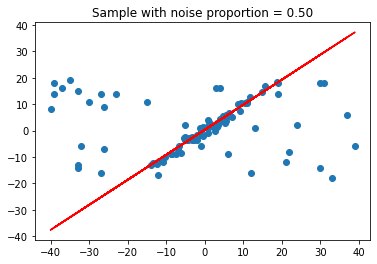

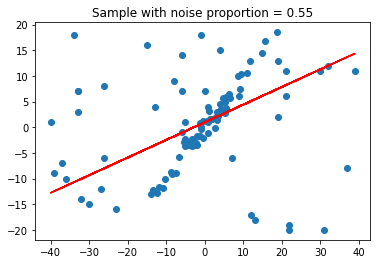

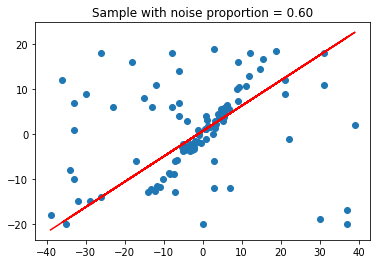

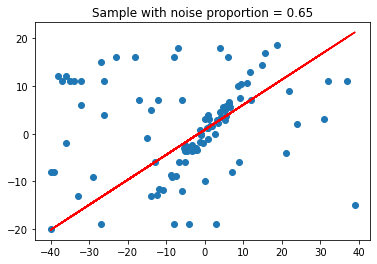

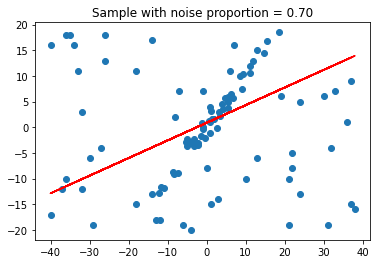

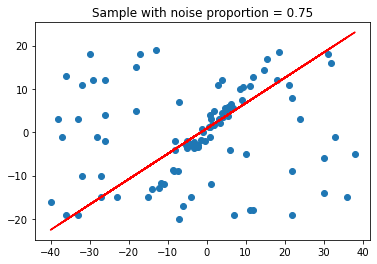

In [27]:
noise_props = np.arange(0, 0.8, 0.05)

for prop in noise_props:
    # Generate noisy sample
    x_noisy, y_noisy = generate_noisy_sample(x, y, prop=prop)
    
    w_opt, n = gradient_descent_cauchy(x_noisy, y_noisy, c=1)
    
    plot_fitted_line(x_noisy, y_noisy, w_opt, title=f'Sample with noise proportion = {prop:.2f}')

For $c=1$, we can see that the function is robust until we have a noise proportion of almost half the data points. This improvement from the LS method is huge. However, once we introduce some more random noise, the sensitivity of the function to the outliers starts to be significative since most of the data is composed of them, which makes sense. Anyways, for a noise proportion higher than 0.75, it wouldn't even make sense to consider a linear regression.

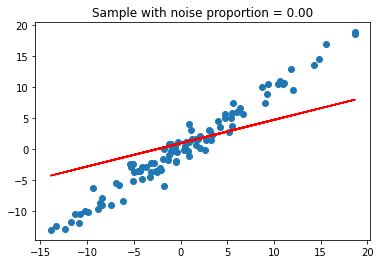

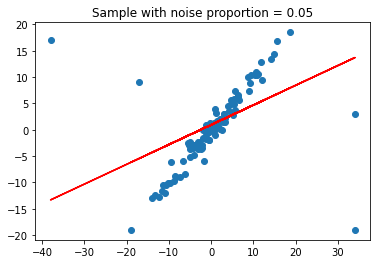

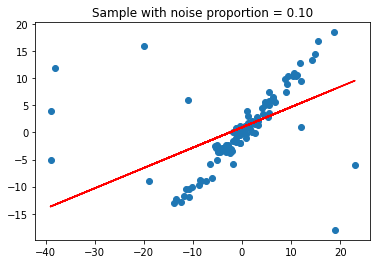

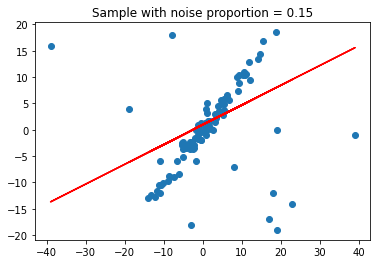

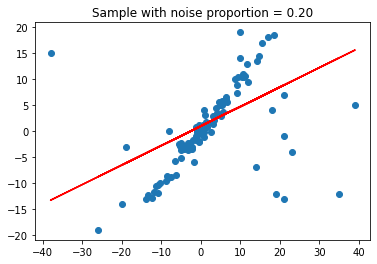

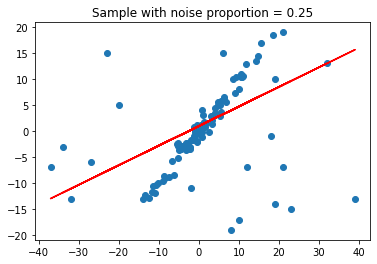

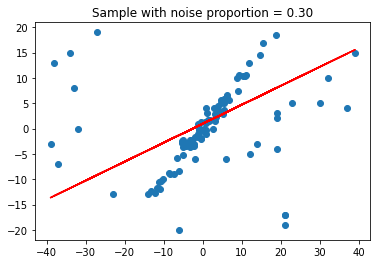

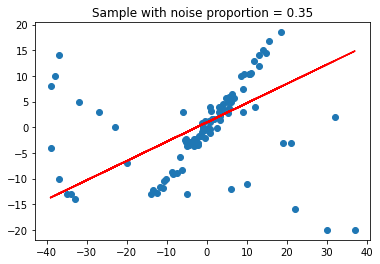

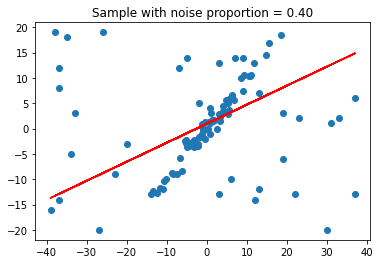

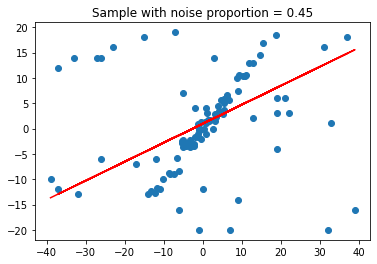

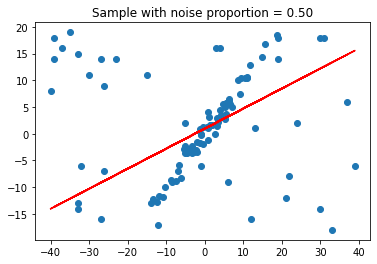

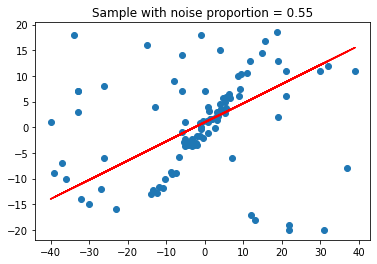

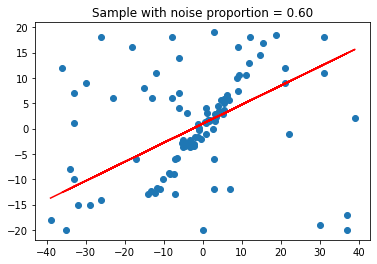

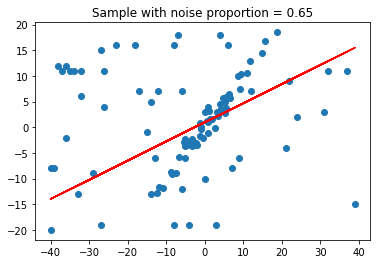

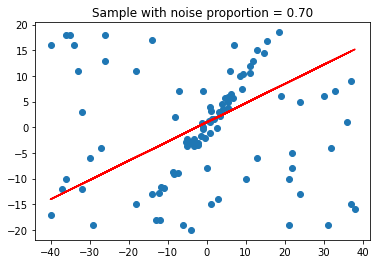

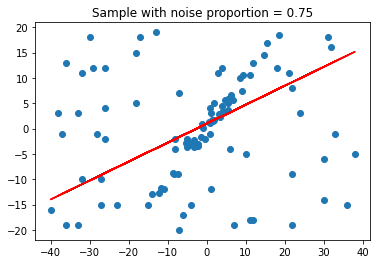

In [28]:
noise_props = np.arange(0, 0.8, 0.05)

for prop in noise_props:
    # Generate noisy sample
    x_noisy, y_noisy = generate_noisy_sample(x, y, prop=prop)
    
    w_opt, n = gradient_descent_cauchy(x_noisy, y_noisy, c=0.01)
    
    plot_fitted_line(x_noisy, y_noisy, w_opt, title=f'Sample with noise proportion = {prop:.2f}')

In this other case and as we explained, $c=0.01$ is so small and, thus, the Cauchy function also tends to be so small that the fits that we obtain present slight changes. We can pressumably say that with smaller values of $c$, the sensitivity to outliers of the Cauchy function is also smaller but the final regression is not good.